# King County Housing EDA

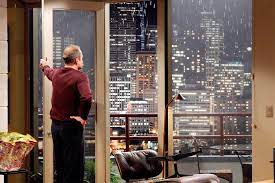

This Notebook is about doing an explorative Data Analysis on a Dataset of Houses sold in the area of King County, Washington, US

It will guide you through the individual steps and explains the thoughts behind it.

So, lets begin!

## 0. Importing modules

First, importing needed modules and setting some parameters for visualizations

In [56]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import re
from scipy.spatial.distance import cdist
import calendar
import matplotlib.patches as mpatches


plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black", 'font.size':20})
plt.rcParams["figure.facecolor"]= "w"
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8.0, 5.0]
SMALL_SIZE = 14
mpl.rc('font', size=SMALL_SIZE)
pd.plotting.register_matplotlib_converters()


## 1. Data

### 1.1 Importing Data

This EDA is using three datasets. 

The main Dataset is the King County House prices dataset and contains 21597 of data records. 

Each record containing 21 fields. 
Let's read the file and have a look at the head.


In [57]:
# King County House Dataset
df = pd.read_csv('data/King_County_House_prices_dataset.csv')

#Show first 3 records
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


Next, we will import a shape file that gives us information about the zip code area borders

This file will be important for visualize our geographical results.

In [58]:
#read the shape file of the zip code areas of king county
zip_shape_df = gpd.read_file('data/Zipcodes/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp') 
zip_shape_df.head(3)


,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry
0,1,98001,98001,033,Standard,King County,AUBURN,148134.771476,5.261214e+08,"POLYGON ((-122.22992 47.35377, -122.22993 47.3..."
1,2,98002,98002,033,Standard,King County,AUBURN,105168.476823,2.044452e+08,"POLYGON ((-122.22921 47.35375, -122.22915 47.3..."
2,3,98003,98003,033,Standard,King County,FEDERAL WAY,121645.069928,3.169812e+08,"POLYGON ((-122.30940 47.35795, -122.30940 47.3..."


In [59]:
#read csv containing population information about the zip code areas in king county
pop_dens = pd.read_csv('data/us_population_density_by_zip_september2020.csv')
pop_dens.head(3)

,zip,population,population_density,city,state,latitude,longitude
0,10162,1726,151834.77,New York,New York,40.7693,-73.9499
1,10028,44987,126067.69,New York,New York,40.7769,-73.9547
2,10128,59856,122356.52,New York,New York,40.7817,-73.9503


### 1.2 Additional Info about Dataset

Next we will look at our data and get some information about the Dtypes.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We got 8 float & 11 Integers Dtypes, but also two 'object' Dtypes.

The column 'date' should contain the date in string format. Column 'sqft_basement' should be the area as a float Dtype. We will find out later why this is not the case.


Also there are 3 columns with NaN values. In a later step we will think about what we do with the missing values. 

### 1.3 Descriptive Statistics of Dataset

To better understand the data we will visualize some of the Feature distributions of our data.

Also we are looking at some descriptive statistic values like mean, min, max or median

In [61]:

def format_number(data_value, indx):
    """ 
    Helper function for formatting large Numbers in X/Y-Tick-Labels
    Returns a formatter for 'set_major_formatter'
    """
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

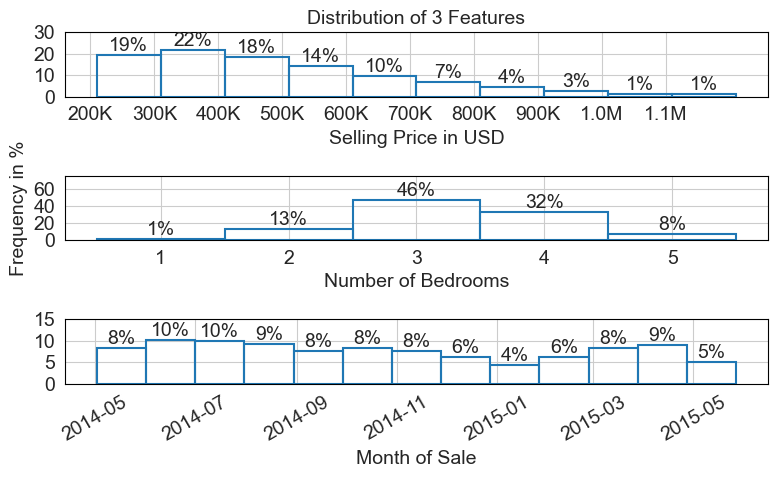

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [62]:
fig, axes = plt.subplots(3,1)
#Number of Houses per price category 
g = sns.histplot(ax=axes[0],data=df,x = 'price',log_scale = (False,False),
    element="bars", stat='percent', fill = False, binwidth = 100e3, binrange=(df.price.quantile(0.05),df.price.quantile(0.95)))
g.set_xticks(np.arange(2e5,12e5,1e5))
g.bar_label(g.containers[0], fmt='%.f%%')
g.set_ylim(0,30)
g.set_xlabel('Selling Price in USD')
g.ticklabel_format(useOffset=False, style='plain')
g.xaxis.set_major_formatter(format_number)
g.set_yticks(np.arange(0,35,10))
g.set_ylabel('')
g.set_title('Distribution of 3 Features',fontsize = 14)
#distribution of bedrooms in sold houses. quantile(0.95) because i dont want to show outliers for better visualisation)
g=sns.histplot(ax=axes[1], data=df, x= 'bedrooms', binwidth=1, binrange=(0.5,df.bedrooms.quantile(0.95)), element="bars", stat='percent', fill = False)
g.bar_label(g.containers[0], fmt='%.f%%',label_type='edge')
g.set_ylim(0,75)
g.set_yticks(np.arange(0,80,20))
g.set_xlabel('Number of Bedrooms')
g.set_ylabel('Frequency in %')

# number of houses sold per month 
g = sns.histplot(ax=axes[2], data=df, x = pd.to_datetime(df.date), binwidth=30, element="bars", stat='percent', fill = False) #bins of size 30 days
plt.xticks(rotation=30)
g.bar_label(g.containers[0], fmt='%.f%%')
g.set_ylim(0,15)
g.set_yticks(np.arange(0,20,5))
g.set_xlabel('Month of Sale')
g.set_ylabel('')
plt.tight_layout()
plt.show()

#show some simple descriptive statistics
df.describe()



We can see that the Selling price distribution is skewed. Most of the Houses sold are in a range between 300k and 650k USD. 

Almost 50 % of the sold houses got 3 bedrooms. Also one record got a big outlier with 33 bedrooms. WOW!

Looking at the Month of Sale Distribution, we can see that less houses were sold in the winter months. Also in the last recorded month there are less houses sold than before. It is possible that we have not all the data available for May 2015.

## 2. Hypotheses

Lets think about three hypthoses we could ask us. Our Stakeholder Thomas is a 43 Year Call Center Employee.
He is married and got 5 Kids. We got 3 main Requirements which we must comply with:

* Very cheap house: Call centre employees earn very little money. Max. House price is 250k USD.
* 4+ Bedrooms: His big Family needs a lot of space to live
* Social Neighbourhood: Thomas & his Family like it to be around people.

Thomas got three Questions he asked us:
* Where do I buy?: Are house prices dependent on location?
* When do i Buy?: Are house prices dependent on location?
* What will I Buy?: Are house prices dependent on location?



Based on this Requirements and Stakeholder Questions we want to validate 3 Hypotheses:
* Buying a Family house in the city is more expensive than buying a house in the countryside. 
* The family house selling price depends on the time of the year.
* Family houses with a low price (< 250k) have a low grade (< 8).

So let's try finding a Answer for Thomas' Questions and the three Hypthoses.



## 3. Data Cleaning

### 3.1 Dtype convertion

First we have to clean the data to be able to work with it better.

In [63]:
#convert dates to datetime dtype
df.date = pd.to_datetime(df.date)
df.yr_renovated = pd.to_datetime(df.yr_renovated)

In [64]:
#Finding out why sqft_basement is no float dtype:
# See what other character can be found in the sqft_basement column besides floats
df[df.sqft_basement.str.findall('[^0-9.]+').str.len() != 0].sqft_basement.unique()

array(['?'], dtype=object)

### 3.2 Handling with NaNs

We now know that the column is no float object because there are rows with an "?" instead of a number

We can replace the ? with  NaN:

In [65]:
df.sqft_basement = df.sqft_basement.replace('?',np.NaN) #replace ? with NaN
df.sqft_basement = pd.to_numeric(df.sqft_basement) #convert column to dtype float64
df.sqft_basement.info()



<class 'pandas.core.series.Series'>
RangeIndex: 21597 entries, 0 to 21596
Series name: sqft_basement
Non-Null Count  Dtype  
--------------  -----  
21143 non-null  float64
dtypes: float64(1)
memory usage: 168.9 KB


Let's look for NaN's and what we can do with them

In [66]:
df.columns[df.isna().any()].tolist() #columns with NaNs
(df.isna().sum()/df.shape[0]*100)[df.isna().sum() != 0] # show Columns with NaN-Frequency


waterfront       11.001528
view              0.291707
sqft_basement     2.102144
yr_renovated     17.789508
dtype: float64

We can see that we got 4 columns with NaN Values. Since we do not need these columns to answer our hypotheses, we will leave the NaNs. 

### 3.3 Add additional columns

To make an analysis based on years, months, weeks and days, new columns are created from the column 'date'.

In [67]:
df['year_sold'] = df.date.dt.year
df['month_sold'] = df.date.dt.month
df['weekday_sold'] = df.date.dt.weekday
df['day_sold'] = df.date.dt.day
df['week_month'] = df['day_sold'].apply(lambda d: (d-1) // 7 + 1 if d < 28 else 4)


### 3.4 Data Selection

Our Stakeholder thomas is only interested in Family Houses with 4 or more Bedrooms (max 6). Because of that, we will only work with a selection of our dataframe.

In [ ]:
#filtered data df_s: only houses with bedrooms between 4 and 6
df_s = df[df.bedrooms > 3][df.bedrooms < 7]

## 4. Preparing a Map

Since one Hypotheses is about geopraphic information we have to prepare a map of King County. 

Let's build a map and visualize the population density just as an example.

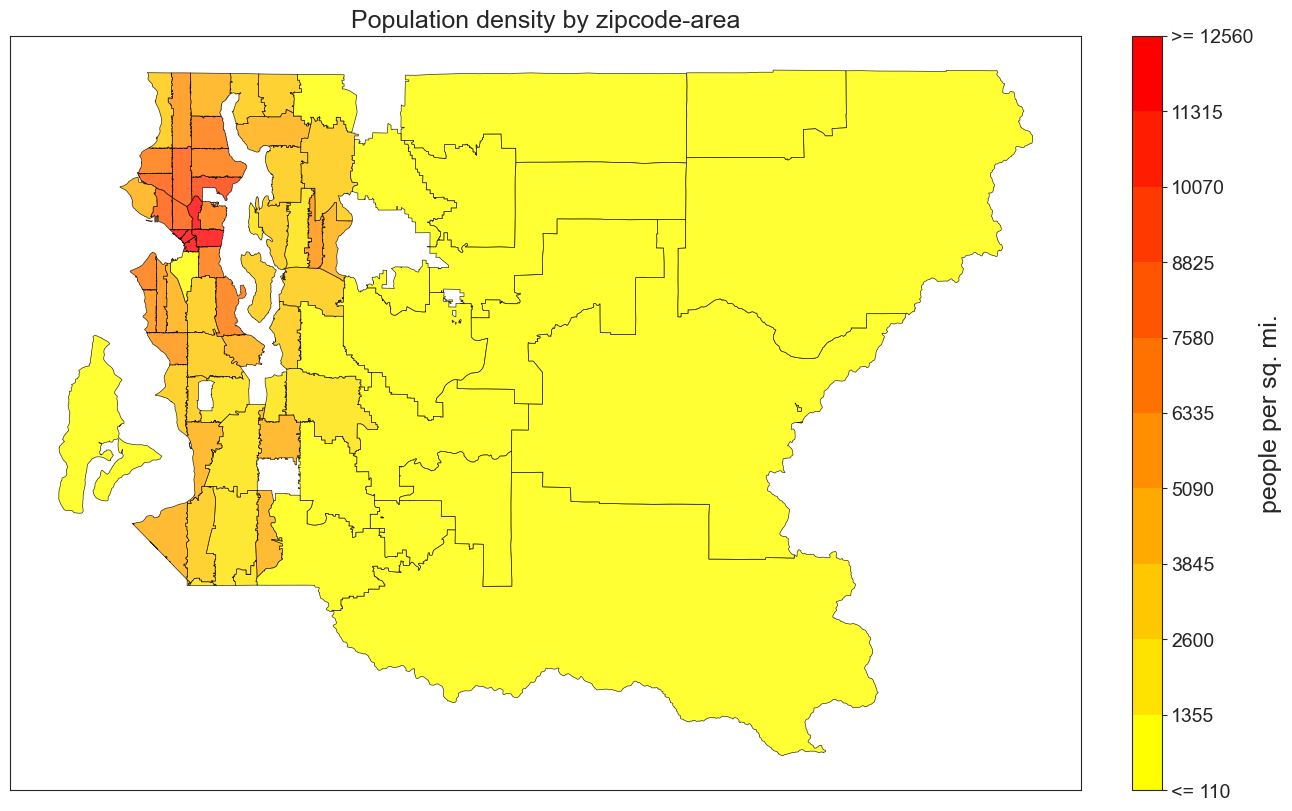

In [80]:
#get zip codes from King County
zip_shape_df = zip_shape_df[zip_shape_df.COUNTY_NAM == 'King County']

#rename zip column to ZIP 
pop_dens = pop_dens.rename({'zip':'ZIP'},inplace=False,axis=1)

#merge both dataframes on ZIP Column
if not 'population_density' in zip_shape_df.columns:
    zip_shape_df= zip_shape_df.merge(pop_dens[['ZIP','population','population_density']],how='left',on='ZIP')
    

#Plot Population density of King County
cmap = plt.cm.autumn_r  # define the colormap
# extract all colors from the .autmn_r
cmaplist = [cmap(i) for i in range(cmap.N)]
sns.set_style('white')

# create a new colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#set bounds to 5 - 95 % interval to deal with outliers
bounds = np.linspace(np.round(zip_shape_df.population_density.quantile(q=0.05),-1), np.round(zip_shape_df.population_density.quantile(q=0.95),-1), 11) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip = True) #out of bounds values will be mapped to 0 or 1 

#plot population density per ZIP code area on map
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10, 4),gridspec_kw={'width_ratios': [50, 1]},)
plt.tight_layout(pad=-10)
zip_shape_df.plot(ax=ax1, edgecolor='black', alpha=0.8, column='population_density',cmap=cmap,categorical = False,linewidth=0.5,norm = norm,legend=False)

#plot colorbar next to the map 
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#remove ticks from map
ax1.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

#set labels etc. 
ax1.set_title('Population density by zipcode-area', size=18)
ax2.set_ylabel('people per sq. mi.', size=18)

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels[0] = '<= ' + labels[0]
labels[-1] = '>= ' + labels[-1] 
ax2.set_yticklabels(labels)
plt.show()


Most of King county got a real low population density. The area with the highest population density is Seattle in western King County. 

# 

## 5. Data Grouping

In order to evaluate the geographical dependency of the House price we will group the data by zipcode

### 5.1 Group by Zip Code Area

In [84]:
df_zip = pd.DataFrame()
df_zip = df_s.groupby('zipcode').mean().reset_index().merge(zip_shape_df[['ZIP','population','population_density']],left_on='zipcode',right_on='ZIP')
df_zip.drop('ZIP',axis=1,inplace=True)
df_zip.head(3)


,zipcode,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,year_sold,month_sold,weekday_sold,day_sold,week_month,population,population_density
0,98001,4.801020e+09,323885.213333,4.133333,2.360000,2304.253333,13458.213333,1.643333,0.0,0.120805,...,-122.270280,2031.940000,9946.693333,2014.380000,6.213333,2.200000,16.253333,2.726667,25771.0,1408.91
1,98002,4.658527e+09,268855.000000,4.343284,2.358209,2141.865672,8136.462687,1.455224,0.0,0.000000,...,-122.213194,1678.865672,8253.761194,2014.313433,7.104478,2.119403,15.970149,2.671642,30815.0,4053.55
2,98003,4.925100e+09,356884.210526,4.231579,2.410526,2524.084211,10859.484211,1.436842,0.0,0.505263,...,-122.310021,2228.073684,10100.252632,2014.357895,6.273684,2.052632,16.684211,2.810526,42255.0,3478.65


### 5.2 Group by Time Intervals


To evaluate the time dependency of the price data we will also group by time intervals. First we will group by month:

In [85]:
#montly mean difference from overall mean of price column
dm_month = df_s.groupby('month_sold').mean() - df_s.price.mean()

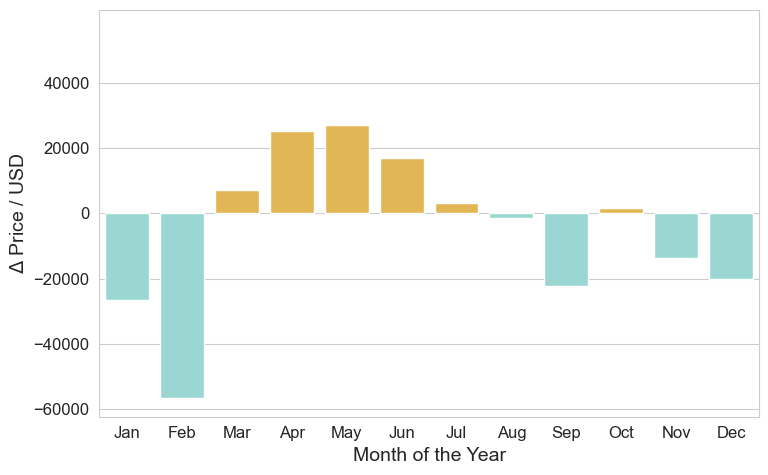

In [87]:
sns.set_style('whitegrid')
fig, ax3 = plt.subplots()
f3 = sns.barplot(data=dm_month,x=dm_month.index,y=dm_month.price,ax=ax3, color = np.array([249, 191, 62])/255)
f4 = sns.barplot(data=dm_week_month,x=dm_week_month.index,y=dm_week_month.price,ax=ax4, color = np.array([249, 191, 62])/255)

f3.set_ylim(- dm_month.price.abs().max() * 1.1,dm_month.price.abs().max() * 1.1)
f4.set_ylim(- dm_week_month.price.abs().max() * 1.1,dm_week_month.price.abs().max() * 1.1)
[x.set_facecolor(np.array([np.array([154, 215, 210])/255])) for x in f3.patches if x.get_height() < 0 ]#
[x.set_facecolor(np.array([np.array([154, 215, 210])/255])) for x in f4.patches if x.get_height() < 0 ]
f3.set_yticks(np.arange(-60000,60000,20000))
f4.set_yticks(np.arange(-20000,21000,10000))
f4.set_ylim(-20000,20000)
f4.set_ylabel('$\Delta$ Price / USD',fontsize = 14)
f3.set_ylabel('$\Delta$ Price / USD',fontsize = 14)
f3.set_xlabel('Month of the Year',fontsize = 14)
f4.set_xlabel('Week of the Month',fontsize = 14)
plt.tight_layout()

f3.set_xticks(np.arange(0,12,1))
f3.set_xticklabels([x[:3] for x in list(calendar.month_name)[1:]],fontsize = 12)
f4.set_xticklabels([1,2,3,4], fontsize = 12)
f3.set_yticklabels(f3.get_yticklabels(), fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


In [ ]:
dm_week_month = df_s.groupby('week_month').mean() - df_s.price.mean() #week mean difference from overall mean of price column

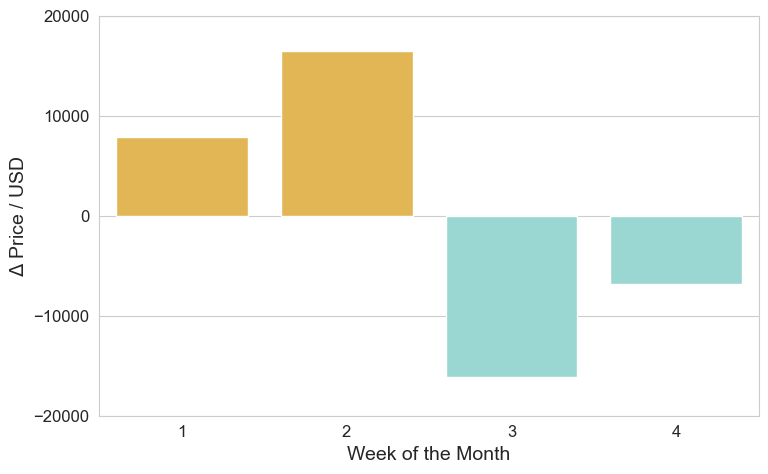

In [88]:
fig, ax4 = plt.subplots()
f4 = sns.barplot(data=dm_week_month,x=dm_week_month.index,y=dm_week_month.price,ax=ax4, color = np.array([249, 191, 62])/255)


f4.set_ylim(- dm_week_month.price.abs().max() * 1.1,dm_week_month.price.abs().max() * 1.1)

[x.set_facecolor(np.array([np.array([154, 215, 210])/255])) for x in f4.patches if x.get_height() < 0 ]

f4.set_yticks(np.arange(-20000,21000,10000))
f4.set_ylim(-20000,20000)
f4.set_ylabel('$\Delta$ Price / USD',fontsize = 14)


f4.set_xlabel('Week of the Month',fontsize = 14)
plt.tight_layout()


f4.set_xticklabels([1,2,3,4], fontsize = 12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### 5.3 Group by Population density
### Answering Hypthoses 1

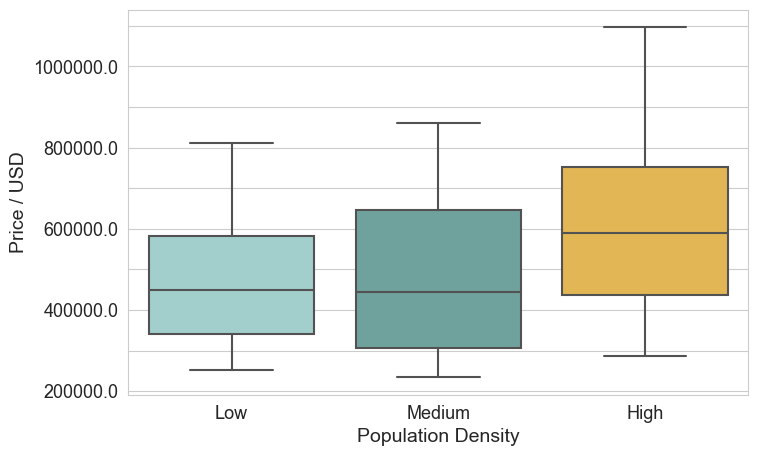

In [83]:
df_zip['q_pop_bins'], bins= pd.qcut(df_zip.population_density,3,retbins=True,labels=['Low','Medium','High'])
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fsize = 14
my_pal = {"Medium": np.array([102, 170, 162])/255, "Low": np.array([154, 215, 210])/255, "High":np.array([249, 191, 62])/255} 
sns.boxplot(x ='q_pop_bins',y='price',data=df_zip,ax=ax,showfliers = False, palette=my_pal)
ax.set_xlabel('Population Density', fontsize = fsize)
ax.set_ylabel('Price / USD', fontsize = fsize)
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(np.arange(2e5, 1.2e6, 1e5),labels=['' if x/1e5%2 else str(x) for x in np.arange(2e5, 1.2e6, 1e5)],fontsize = fsize-1)
plt.xticks(fontsize = fsize-1)
plt.gcf().dpi = 100
plt.gcf().set_size_inches(8,5)



<AxesSubplot: xlabel='q_pop_bins', ylabel='price'>

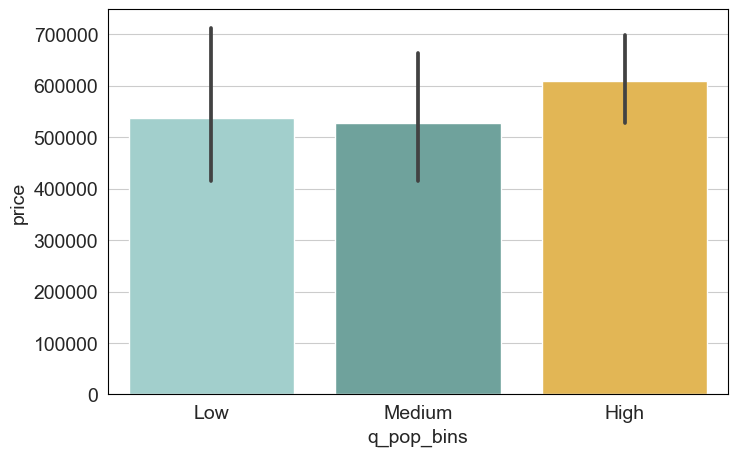

In [72]:
sns.barplot(x ='q_pop_bins',y='price',data=df_zip, palette=my_pal)

## 6. Stackholder Recommendations

First of all we want so only select the houses with more than 3 bedrooms 

In [73]:
family_houses = df[df.bedrooms > 3][df.bedrooms < 7]


have a look where we can find most of these houses. Lets group by Zipcode

In [74]:
fam_house_zip = family_houses.groupby('zipcode').size().reset_index()
#Merge the number of houses into the zip_shape_df
zip_shape_fam_houses = pd.merge(zip_shape_df,fam_house_zip, left_on = 'ZIP', right_on = 'zipcode')
zip_shape_fam_houses = zip_shape_fam_houses.set_axis([*zip_shape_fam_houses.columns[:-1], 'Num_of_fam_houses'], axis=1, inplace=False).sort_values(by='Num_of_fam_houses',ascending=False)
zip_shape_fam_houses.head()


fam_house_zip = family_houses.groupby('zipcode').median().reset_index()
#Merge the number of houses into the zip_shape_df
zip_shape_fam_houses = pd.merge(zip_shape_fam_houses,fam_house_zip[['zipcode','sqft_living','sqft_lot','price']], left_on = 'ZIP', right_on = 'zipcode')
zip_shape_fam_houses = zip_shape_fam_houses.set_axis([*zip_shape_fam_houses.columns[:-1], 'Mean_price'], axis=1, inplace=False).sort_values(by='Mean_price',ascending=True)
zip_shape_fam_houses.drop(['ZIP', 'zipcode_x','zipcode_y'],axis = 1).head()

,OBJECTID,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry,population,population_density,Num_of_fam_houses,sqft_living,sqft_lot,Mean_price
53,2,98002,033,Standard,King County,AUBURN,105168.476823,2.044452e+08,"POLYGON ((-122.22921 47.35375, -122.22915 47.3...",30815.0,4053.55,67,2120.0,7665.0,269950.0
52,94,98168,033,Standard,King County,SEATTLE,105513.044308,2.589595e+08,"POLYGON ((-122.29151 47.51370, -122.29188 47.5...",30198.0,3295.07,71,1850.0,8500.0,273500.0
61,28,98032,033,Standard,King County,KENT,162578.137631,4.804289e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",28778.0,1726.83,49,2190.0,8625.0,280927.0
21,1,98001,033,Standard,King County,AUBURN,148134.771476,5.261214e+08,"POLYGON ((-122.22992 47.35377, -122.22993 47.3...",25771.0,1408.91,150,2185.5,8027.0,295750.0
43,100,98198,033,Standard,King County,SEATTLE,120954.750650,2.129129e+08,"POLYGON ((-122.31455 47.42435, -122.31454 47.4...",33561.0,4488.33,91,2050.0,9009.0,295832.0


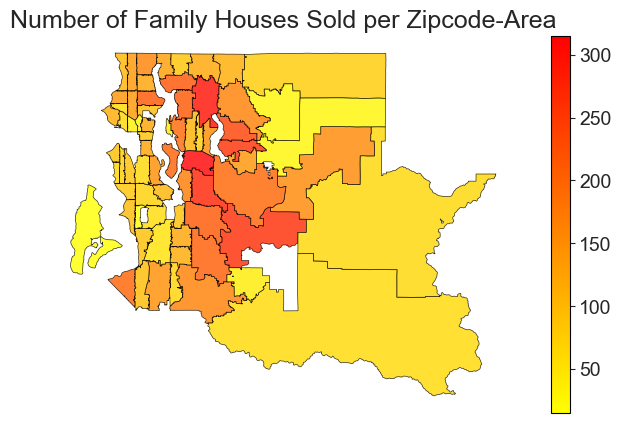

In [75]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 4))
plt.tight_layout(pad=-10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_fam_houses.plot(ax=ax1, edgecolor='black', alpha=0.8, column=zip_shape_fam_houses.Num_of_fam_houses,cmap='autumn_r',categorical = False,linewidth=0.5,legend=True)
ax1.set_title('Number of Family Houses Sold per Zipcode-Area',fontsize = 18)
plt.axis('off')
fig.set_size_inches(5, 2)

### Also we can take a look a the Areas with the cheapest Family houses

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry,population,population_density,zipcode_x,Num_of_fam_houses,zipcode_y,sqft_living,sqft_lot,Mean_price
53,2,98002,98002,033,Standard,King County,AUBURN,105168.476823,2.044452e+08,"POLYGON ((-122.22921 47.35375, -122.22915 47.3...",30815.0,4053.55,98002,67,98002,2120.0,7665.0,269950.0
52,94,98168,98168,033,Standard,King County,SEATTLE,105513.044308,2.589595e+08,"POLYGON ((-122.29151 47.51370, -122.29188 47.5...",30198.0,3295.07,98168,71,98168,1850.0,8500.0,273500.0
61,28,98032,98032,033,Standard,King County,KENT,162578.137631,4.804289e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",28778.0,1726.83,98032,49,98032,2190.0,8625.0,280927.0


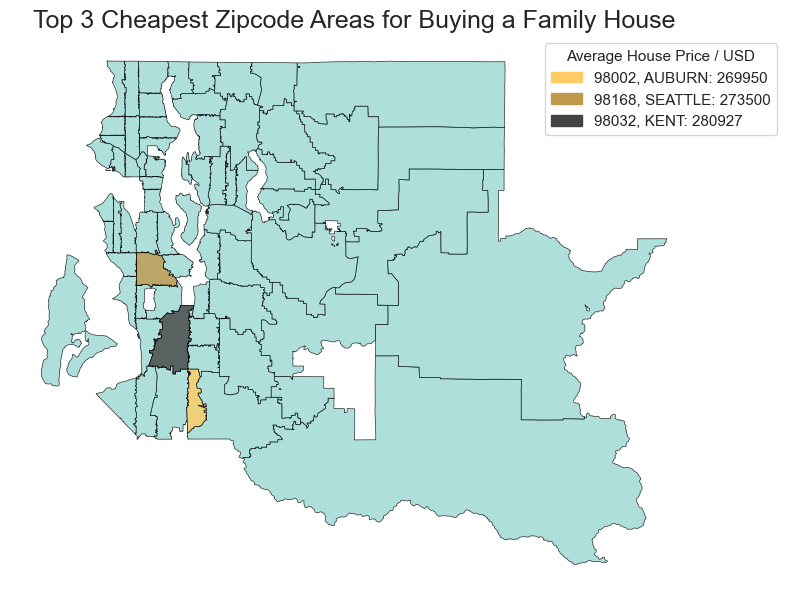

In [76]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(4, 2),width_ratios=[10,1])
plt.tight_layout(pad = -10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_fam_houses.plot(ax=ax1, color = np.array([154, 215, 210])/255, edgecolor='black', alpha=0.8,linewidth=0.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [np.array([255, 203, 100])/255,0.75 * np.array([255, 203, 100])/255,np.array([67, 67, 67])/255])
p = (zip_shape_fam_houses.iloc[:3]
    .plot(ax=ax1, edgecolor='black', alpha=0.8, 
        column=zip_shape_fam_houses.iloc[:3].Mean_price.astype(int),
        cmap = cmap,categorical = True,linewidth=0.5)
    )

ax1.set_title('Top 3 Cheapest Zipcode Areas for Buying a Family House',fontsize = 18)
ax1.axis('off')
ax2.axis('off')
#p.get_legend().set_title('Population Density\npeople per sq. mi.')
#p.get_legend().set_title('Average House price / USD')

#list(p.get_legend_handles_labels().__str__)
#zip_shape_fam_houses.iloc[:3]
# create fake legend because it could not change the labels


a_patch = mpatches.Patch(color=np.array([255, 203, 100])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[0] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[0] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[0])))
b_patch = mpatches.Patch(color=0.75 * np.array([255, 203, 100])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[1] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[1] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[1])))
c_patch = mpatches.Patch(color=np.array([67, 67, 67])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[2] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[2] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[2])))
ax2.legend(handles=[a_patch, b_patch, c_patch],title = 'Average House Price / USD',fontsize = 11, title_fontsize = 11, loc = 'upper right')

#plt.gca().legend([1,2,3],['1','2','3'])

fig.set_size_inches(5, 2)

zip_shape_fam_houses.iloc[:3]

# Grade of family houses

grade
5     3.485255
6    23.592493
7    64.879357
8     8.042895
dtype: float64

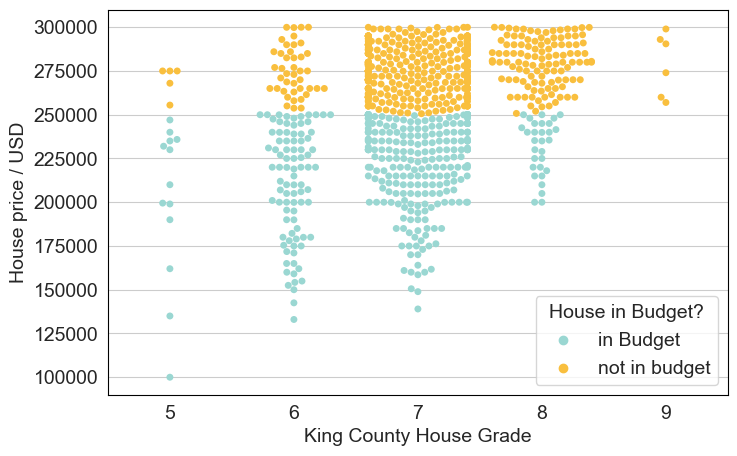

In [77]:
family_houses['grade_cat'] = np.where(family_houses.grade < 7, 'lower 7', 'higher 7')
family_houses['price_ok'] = np.where(family_houses.price <= 250e3, 'in Budget', 'not in budget')
#p = sns.boxplot(data=family_houses,y = 'price', x='grade_cat',showfliers=False)

p.set_ylim(0,9e5)

fam_cheap = family_houses[family_houses.price < 300e3]

sns.swarmplot(fam_cheap,y='price',x='grade', hue='price_ok', palette=[np.array([154, 215, 210])/255,np.array([249, 191, 62])/255])

plt.ylabel('House price / USD',fontsize = 14)
plt.legend(title='House in Budget?')
plt.xlabel('King County House Grade', fontsize = 14)
plt.gcf().set_size_inches(8,5)
fam_ch_grade = fam_cheap[fam_cheap.price_ok == 'in Budget'].groupby(['grade']).size()
fam_ch_grade = 100 * fam_ch_grade / fam_ch_grade.sum()
fam_ch_grade
